In [1]:
import tensorflow as tf
import numpy as np
import math
from censai import PhysicalModel, RIMSharedUnet
from censai.models import SharedUnetModel
from censai.data.lenses_tng import decode_train, decode_physical_model_info, preprocess
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, glob, time
from datetime import datetime
from tensorboard.plugins.hparams import api as hp
import random
    
    
RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "batch_norm",
    "dropout",
    "kernel_l2_amp",
    "bias_l2_amp",
    "kernel_l1_amp",
    "bias_l1_amp",
    "activation",
    "alpha",
    "initializer",
]

In [2]:
# import tensorflow as tf
# from censai.models import SharedUnetModel
# from censai.definitions import logkappa_normalization, log_10, DTYPE, logit, lrelu4p
# from censai import PhysicalModel
# from censai.utils import nulltape

# # LAM = -0.10455389589556062
# # LAM = -0.5369885858903738
# # LAM = 0.42627448994956957 # applied with log_10
# # LAM = -1.8944241461145863
# LAM = -0.8
# def boxcox(x):
#     return (x**LAM - 1) / LAM

# def boxcox_inverse(x):
# #     return tf.math.exp(tf.math.log(G**(LAM-1) * LAM * x + 1) / LAM)
#     return tf.math.exp(tf.math.log(G * LAM * x + 1) / LAM)

# class RIMSharedUnet:
#     """
#     Architecture has only 1 Unet. Source and kappa information are stacked along channel dimension.

#     There are 2 intended structures:
#         1. Kappa has a larger shape than Source tensor:
#             1 - Use a half-strided convolution to upsample the output of the Unet
#             3 - Use bilinear interpolation to upsample
#         2. Kappa and Source have the same tensor shape -> Identity layer

#     In any case, we use the Source shape for the Unet
#     """
#     def __init__(
#             self,
#             physical_model: PhysicalModel,
#             unet: SharedUnetModel,
#             steps: int,
#             adam=True,
#             kappalog=True,
#             kappa_normalize=False,
#             source_link="relu",
#             beta_1=0.9,
#             beta_2=0.999,
#             epsilon=1e-8,
#             kappa_init=1e-1,
#             source_init=1e-3
#     ):
#         self.physical_model = physical_model
#         self.kappa_pixels = physical_model.kappa_pixels
#         self.source_pixels = physical_model.src_pixels
#         self.unet = unet
#         self.steps = steps
#         self.adam = adam
#         self.kappalog = kappalog
#         self._source_link_func = source_link
#         self.kappa_normalize = kappa_normalize
#         self.beta_1 = beta_1
#         self.beta_2 = beta_2
#         self.epsilon = epsilon
#         self._kappa_init = kappa_init
#         self._source_init = source_init
        
#         self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: boxcox(log_10(x) + 3))
#         self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**(boxcox_inverse(x) - 3))

# #         if self.kappalog:
# #             if self.kappa_normalize:
# #                 self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: logkappa_normalization(log_10(x), forward=True))
# #                 self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**(logkappa_normalization(x, forward=False)))
# #             else:
# #                 self.kappa_inverse_link = tf.keras.layers.Lambda(lambda x: log_10(x))
# #                 self.kappa_link = tf.keras.layers.Lambda(lambda x: 10**x)
# #         else:
# #             self.kappa_link = tf.identity
# #             self.kappa_inverse_link = tf.identity
        

#         if self._source_link_func == "exp":
#             self.source_inverse_link = tf.keras.layers.Lambda(lambda x: tf.math.log(x + 1e-6))
#             self.source_link = tf.keras.layers.Lambda(lambda x: tf.math.exp(x))
#         elif self._source_link_func == "identity":
#             self.source_inverse_link = tf.identity
#             self.source_link = tf.identity
#         elif self._source_link_func == "relu":
#             self.source_inverse_link = tf.identity
#             self.source_link = tf.nn.relu
#         elif self._source_link_func == "sigmoid":
#             self.source_inverse_link = logit
#             self.source_link = tf.nn.sigmoid
#         elif self._source_link_func == "lrelu4p":
#             self.source_inverse_link = tf.identity
#             self.source_link = lrelu4p
#         else:
#             raise NotImplementedError(f"{source_link} not in ['exp', 'identity', 'relu', 'lrelu4p', 'sigmoid']")

#     def initial_states(self, batch_size):
#         # Define initial guess in physical space, then apply inverse link function to bring them in prediction space
#         source_init = self.source_inverse_link(tf.ones(shape=(batch_size, self.source_pixels, self.source_pixels, 1)) * self._source_init)
#         kappa_init = self.kappa_inverse_link(tf.ones(shape=(batch_size, self.kappa_pixels, self.kappa_pixels, 1)) * self._kappa_init)
#         states = self.unet.init_hidden_states(self.source_pixels, batch_size)
#         return source_init, kappa_init, states

#     def grad_update(self, grad1, grad2, time_step):
#         if self.adam:
#             if time_step == 0:  # reset mean and variance for time t=-1
#                 self._grad_mean1 = tf.zeros_like(grad1)
#                 self._grad_var1 = tf.zeros_like(grad1)
#                 self._grad_mean2 = tf.zeros_like(grad2)
#                 self._grad_var2 = tf.zeros_like(grad2)
#             self._grad_mean1 = self. beta_1 * self._grad_mean1 + (1 - self.beta_1) * grad1
#             self._grad_var1  = self.beta_2 * self._grad_var1 + (1 - self.beta_2) * tf.square(grad1)
#             self._grad_mean2 = self. beta_1 * self._grad_mean2 + (1 - self.beta_1) * grad2
#             self._grad_var2  = self.beta_2 * self._grad_var2 + (1 - self.beta_2) * tf.square(grad2)
#             # for grad update, unbias the moments
#             m_hat1 = self._grad_mean1 / (1 - self.beta_1**(time_step + 1))
#             v_hat1 = self._grad_var1 / (1 - self.beta_2**(time_step + 1))
#             m_hat2 = self._grad_mean2 / (1 - self.beta_1**(time_step + 1))
#             v_hat2 = self._grad_var2 / (1 - self.beta_2**(time_step + 1))
#             return m_hat1 / (tf.sqrt(v_hat1) + self.epsilon), m_hat2 / (tf.sqrt(v_hat2) + self.epsilon)
#         else:
#             return grad1, grad2

#     def time_step(self, source, kappa, source_grad, kappa_grad, states, scope=None):
#         source, kappa, states = self.unet(source, kappa, source_grad, kappa_grad, states)
#         return source, kappa, states

#     def __call__(self, lensed_image, outer_tape=nulltape):
#         return self.call(lensed_image, outer_tape)

#     def call(self, lensed_image, outer_tape=nulltape):
#         """
#         Used in training. Return linked kappa and source maps.
#         """
#         batch_size = lensed_image.shape[0]
#         source, kappa, states = self.initial_states(batch_size)

#         source_series = tf.TensorArray(DTYPE, size=self.steps)  # equivalent to empty list and append, but using tensorflow
#         kappa_series = tf.TensorArray(DTYPE, size=self.steps)
#         chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
#         for current_step in range(self.steps):
#             with outer_tape.stop_recording():
#                 with tf.GradientTape() as g:
#                     g.watch(source)
#                     g.watch(kappa)
#                     log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
#                     cost = tf.reduce_mean(log_likelihood)
#                 source_grad, kappa_grad = g.gradient(cost, [source, kappa])
#                 source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
#             source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
#             source_series = source_series.write(index=current_step, value=source)
#             kappa_series = kappa_series.write(index=current_step, value=kappa)
#             chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
#         return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()

#     def predict(self, lensed_image):
#         """
#         Used in inference. Return physical kappa and source maps.
#         """
#         batch_size = lensed_image.shape[0]
#         source, kappa, states = self.initial_states(batch_size)

#         source_series = tf.TensorArray(DTYPE, size=self.steps)  # equivalent to empty list and append, but using tensorflow
#         kappa_series = tf.TensorArray(DTYPE, size=self.steps)
#         chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
#         for current_step in range(self.steps):
#             with tf.GradientTape() as g:
#                 g.watch(source)
#                 g.watch(kappa)
#                 log_likelihood = self.physical_model.log_likelihood(y_true=lensed_image, source=self.source_link(source), kappa=self.kappa_link(kappa))
#                 cost = tf.reduce_mean(log_likelihood)
#             source_grad, kappa_grad = g.gradient(cost, [source, kappa])
#             source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
#             source, kappa, states = self.time_step(source, kappa, source_grad, kappa_grad, states)
#             source_series = source_series.write(index=current_step, value=self.source_link(source))
#             kappa_series = kappa_series.write(index=current_step, value=self.kappa_link(kappa))
#             chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
#         return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()  # stack along 0-th dimension

#     def cost_function(self, lensed_image, source, kappa, outer_tape=nulltape, reduction=True):
#         """

#         Args:
#             lensed_image: Batch of lensed images
#             source: Batch of source images
#             kappa: Batch of kappa maps
#             reduction: Whether or not to reduce the batch dimension in computing the loss or not

#         Returns: The average loss over pixels, time steps and (if reduction=True) batch size.

#         """
#         source_series, kappa_series, chi_squared = self.call(lensed_image, outer_tape=outer_tape)
#         source_cost = tf.reduce_sum(tf.square(source_series - self.source_inverse_link(source)), axis=0) / self.steps
#         kappa_cost = tf.reduce_sum(tf.square(kappa_series - self.kappa_inverse_link(kappa)), axis=0) / self.steps
#         chi = tf.reduce_sum(chi_squared, axis=0) / self.steps

#         if reduction:
#             return tf.reduce_mean(source_cost) + tf.reduce_mean(kappa_cost), tf.reduce_mean(chi)
#         else:
#             return tf.reduce_mean(source_cost, axis=(1, 2, 3)) + tf.reduce_mean(kappa_cost, axis=(1, 2, 3)), chi



In [3]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                               block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for physical_params in dataset.map(decode_physical_model_info):
        break
    dataset = dataset.map(decode_train).map(preprocess)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file)
    dataset = dataset.shuffle(buffer_size=args.buffer_size).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(math.floor(args.train_split * args.total_items / args.batch_size)) # dont forget to divide by batch size!
    val_dataset = dataset.skip(math.floor(args.train_split * args.total_items / args.batch_size))
    val_dataset = val_dataset.take(math.ceil((1 - args.train_split) * args.total_items / args.batch_size))
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    if args.raytracer is not None:
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    phys = PhysicalModel(
        pixels=physical_params["pixels"].numpy(),
        kappa_pixels=physical_params["kappa pixels"].numpy(),
        src_pixels=physical_params["src pixels"].numpy(),
        image_fov=physical_params["image fov"].numpy(),
        kappa_fov=physical_params["kappa fov"].numpy(),
        src_fov=physical_params["source fov"].numpy(),
        method=args.forward_method,
        noise_rms=physical_params["noise rms"].numpy(),
        raytracer=raytracer,
        psf_sigma=physical_params["psf sigma"].numpy()
    )

    unet = SharedUnetModel(
        filters=args.filters,
        filter_scaling=args.filter_scaling,
        kernel_size=args.kernel_size,
        layers=args.layers,
        block_conv_layers=args.block_conv_layers,
        strides=args.strides,
        bottleneck_kernel_size=args.bottleneck_kernel_size,
        bottleneck_filters=args.bottleneck_filters,
        resampling_kernel_size=args.resampling_kernel_size,
        gru_kernel_size=args.gru_kernel_size,
        upsampling_interpolation=args.upsampling_interpolation,
        kernel_l2_amp=args.kernel_l2_amp,
        bias_l2_amp=args.bias_l2_amp,
        kernel_l1_amp=args.kernel_l1_amp,
        bias_l1_amp=args.bias_l1_amp,
        activation=args.activation,
        alpha=args.alpha,
        initializer=args.initializer,
    )
    rim = RIMSharedUnet(
        physical_model=phys,
        unet=unet,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
        # # weights for time steps in the loss function
        # if args.time_weights == "uniform":
        #     wt = tf.ones(shape=(args.steps), dtype=DTYPE) / args.steps
        # elif args.time_weigth == "linear":
        #     wt = 2 * (tf.range(args.steps, dtype=DTYPE) + 1) / args.steps / (args.steps + 1)
        # elif args.time_weight == "quadratic":
        #     wt = 6 * (tf.range(args.steps, dtype=DTYPE) + 1)**2 / args.steps / (args.steps + 1) / (2 * args.steps + 1)
        # wt = wt[..., tf.newaxis]  # [steps, batch]
    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id + "_" + args.logname
        model_id = args.model_id
    elif args.logname is not None:
        logname = args.logname
        model_id = logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
        model_id = logname
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        old_checkpoints_dir = os.path.join(args.model_dir, model_id)  # in case they differ we load model from a different directory
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, old_checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
        if old_checkpoints_dir != checkpoints_dir:
            # save progress in another directory.
            checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(inputs):
        X, source, kappa = inputs
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            source_series, kappa_series, chi_squared = rim.call(X, outer_tape=tape)
            # mean over image residuals
            source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
            kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
            # weighted mean over time steps
            source_cost = tf.reduce_sum(source_cost, axis=0)
            kappa_cost = tf.reduce_sum(kappa_cost, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

#     @tf.function
#     def distributed_train_step(dist_inputs):
#         per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(train_step, args=(dist_inputs,))
#         # Replica losses are aggregated by summing them
#         global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
#         global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
#         global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
#         global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
#         return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

    def test_step(inputs):
        X, source, kappa = inputs
        source_series, kappa_series, chi_squared = rim.call(X)
        # mean over image residuals
        source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
        kappa_cost = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
        # weighted mean over time steps
        source_cost = tf.reduce_sum(source_cost, axis=0)
        kappa_cost = tf.reduce_sum(kappa_cost, axis=0)
        # final cost is mean over global batch size
        cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        chi_squared = tf.reduce_sum(chi_squared) / args.batch_size
        source_cost = tf.reduce_sum(source_cost) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

#     @tf.function
#     def distributed_test_step(dist_inputs):
#         per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(test_step, args=(dist_inputs,))
#         # Replica losses are aggregated by summing them
#         global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
#         global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
#         global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
#         global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
#         return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    epoch_source_loss = tf.metrics.Mean()
    epoch_kappa_loss = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    val_source_loss = tf.metrics.Mean()
    val_kappa_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "train_source_cost": [],
        "train_kappa_cost": [],
        "val_cost": [],
        "val_chi_squared": [],
        "val_source_cost": [],
        "val_kappa_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
        epoch_start = time.time()
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        epoch_source_loss.reset_states()
        epoch_kappa_loss.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, inputs in enumerate(train_dataset):
                start = time.time()
                cost, chi_squared, source_cost, kappa_cost = train_step(inputs)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_source_loss.update_state([source_cost])
                epoch_kappa_loss.update_state([kappa_cost])
                step += 1
#             # last batch we make a summary of residuals
#             for res_idx in range(min(args.n_residuals, args.batch_size)):
#                 lens_true = inputs[0][res_idx, ...]
#                 source_true = inputs[1][res_idx, ...]
#                 kappa_true = inputs[2][res_idx, ...]
#                 source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
#                 tf.summary.image(f"Residuals {res_idx}",
#                                  plot_to_image(
#                                      residual_plot(
#                                          lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...],
#                                          kappa_pred[-1][0, ...], chi_squared[-1][0]
#                                      )), step=step)

            # ========== Validation set ===================
            val_loss.reset_states()
            val_chi_squared.reset_states()
            val_source_loss.reset_states()
            val_kappa_loss.reset_states()
            for inputs in val_dataset:
                cost, chi_squared, source_cost, kappa_cost = test_step(inputs)
                val_loss.update_state([cost])
                val_chi_squared.update_state([chi_squared])
                val_source_loss.update_state([source_cost])
                val_kappa_loss.update_state([kappa_cost])

#             for res_idx in range(min(args.n_residuals, args.batch_size, math.ceil((1 - args.train_split) * args.total_items))):
#                 lens_true = distributed_inputs[0][res_idx, ...]
#                 source_true = distributed_inputs[1][res_idx, ...]
#                 kappa_true = distributed_inputs[2][res_idx, ...]
#                 source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
#                 tf.summary.image(f"Val Residuals {res_idx}",
#                                  plot_to_image(
#                                      residual_plot(
#                                          lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...],
#                                          kappa_pred[-1][0, ...], chi_squared[-1][0]
#                                      )), step=step)
            val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
            val_chi_sq = val_chi_squared.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
            val_kappa_cost = val_kappa_loss.result().numpy()
            train_kappa_cost = epoch_kappa_loss.result().numpy()
            val_source_cost = val_source_loss.result().numpy()
            train_source_cost = epoch_source_loss.result().numpy()
            tf.summary.scalar("Time per step", _time, step=step)
            tf.summary.scalar("Chi Squared", train_chi_sq, step=step)
            tf.summary.scalar("Kappa cost", train_kappa_cost, step=step)
            tf.summary.scalar("Val Kappa cost", val_kappa_cost, step=step)
            tf.summary.scalar("Source cost", train_source_cost, step=step)
            tf.summary.scalar("Val Source cost", val_source_cost, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
            tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
            tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| learning rate {optim.lr(step).numpy():.2e} "
              f"| kappa cost {train_kappa_cost:.2e} | source cost {train_source_cost:.2e} | chi sq {train_chi_sq:.2e}")
        history["train_cost"].append(train_cost)
        history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
        history["val_chi_squared"].append(val_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["train_kappa_cost"].append(train_kappa_cost)
        history["train_source_cost"].append(train_source_cost)
        history["val_kappa_cost"].append(val_kappa_cost)
        history["val_source_cost"].append(val_source_cost)

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return rim, phys, train_dataset, val_dataset



In [4]:
from argparse import ArgumentParser
import json
parser = ArgumentParser()

parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",        default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")
parser.add_argument("--source_link",        default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",         default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",        default=1e-3,   type=float,     help="Initial value of source for RIM")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=float)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--bottleneck_filters",                         default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--batch_norm",                                 action="store_true")
parser.add_argument("--dropout",                                    default=None,   type=float)
parser.add_argument("--kernel_l2_amp",                              default=0,      type=float)
parser.add_argument("--bias_l2_amp",                                default=0,      type=float)
parser.add_argument("--kernel_l1_amp",                              default=0,      type=float)
parser.add_argument("--bias_l1_amp",                                default=0,      type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.1,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given moment.")
parser.add_argument("--buffer_size",            default=1000,   type=int,       help="Buffer size for shuffling at each epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")
# parser.add_argument("--time_weights",           default="uniform",              help="uniform: w_t=1 for all t, linear: w_t~t, quadratic: w_t~t^2")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,    nargs="+",     help="A json filepath that will override every command line parameters. "
                                                                             "Useful for reproducibility")

_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [10]:
import sys
sys.argv = ['']
args = parser.parse_args(
 f"--datasets {os.getenv('HOME')}/scratch/Censai/data/lenses512_hk128_TNG100 "\
  f"--compression_type=GZIP "\
  f"--forward_method=fft "\
  f"--epochs=1000 "\
  f"--max_time=1 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=50 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=20 "\
  f"--tolerance=0.01 "\
  f"--batch_size=1 "\
  f"--train_split=1 "\
  f"--total_items=1 "\
  f"--block_length=1 "\
  f"--buffer_size=1 "\
  f"--steps=2 "\
  f"--adam "\
  f"--kappalog "\
  f"--source_link=lrelu4p "\
  f"--filters=16 "\
  f"--filter_scaling=1 "\
  f"--kernel_size=3 "\
  f"--layers=3 "\
  f"--block_conv_layers=1 "\
  f"--resampling_kernel_size=3 "\
  f"--gru_kernel_size=3 "\
  f"--batch_norm "\
#   f"--dropout=0.1 "\
  f"--upsampling_interpolation "\
  f"--kernel_l2_amp=1e-4 "\
  f"--bias_l2_amp=1e-4 "\
  f"--alpha=0.1 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIM_SharedUnet128_Interactive "\
  f"--track_train "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--seed=24 "\
  f"--n_residuals=0".split()

)

cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

epoch 0 | train loss 3.231e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 3.01e-01 | source cost 2.25e-02 | chi sq 4.21e+01
epoch 1 | train loss 3.158e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.99e-01 | source cost 1.67e-02 | chi sq 4.18e+01
epoch 2 | train loss 3.104e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.98e-01 | source cost 1.29e-02 | chi sq 4.17e+01
epoch 3 | train loss 3.052e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.94e-01 | source cost 1.07e-02 | chi sq 4.16e+01
epoch 4 | train loss 3.034e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.93e-01 | source cost 9.92e-03 | chi sq 4.16e+01
epoch 5 | train loss 3.031e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.94e-01 | source cost 9.56e-03 | chi sq 4.17e+01
epoch 6 | train loss 3.018e-01 | val loss 0.000e+00 | learning rate 1.00e-04 | kappa cost 2.92e-01 | source cost 9.56e-03 | chi sq 4.17e+01
epoch 7 | train loss

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-5-cf8e40212add>", line 53, in <module>
    rim, phys, train_dataset, val_dataset = main(args)  File "<ipython-input-3-9aef21e6de25>", line 312, in main
    tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)  File "<ipython-input-3-9aef21e6de25>", line 160, in train_step
    cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size  File "/lustre04/scratch/aadam/Censai/censai/rim_shared_unet.py", line 131, in call
    source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


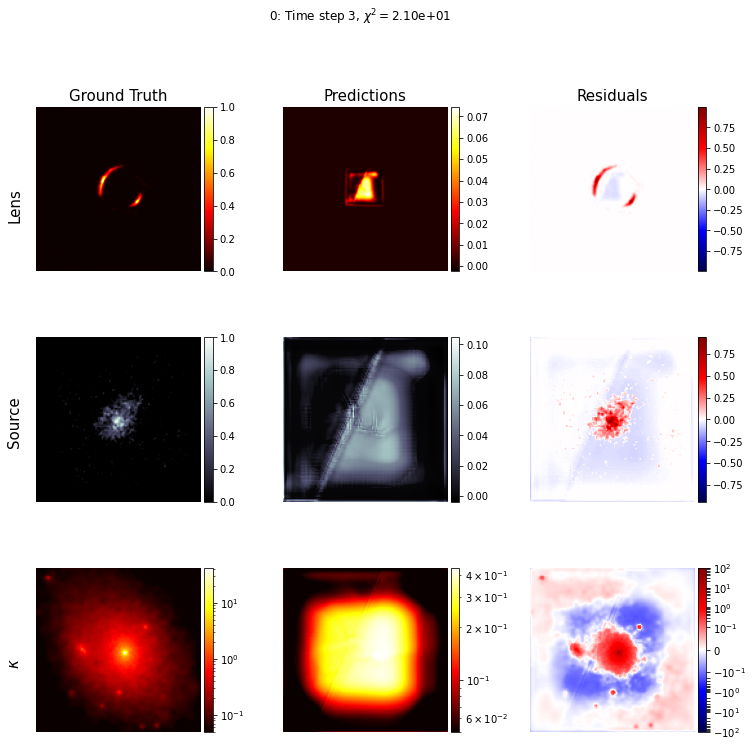

In [11]:
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        lens_true = distributed_inputs[0][res_idx]
        lens_true /= tf.reduce_max(lens_true, axis=(0, 1, 2), keepdims=True)
        source_true = distributed_inputs[1][res_idx]
        kappa_true = distributed_inputs[2][res_idx]
        source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None])
        lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0]
        fig = residual_plot(lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...], kappa_pred[-1][0, ...], chi_squared[-1][0])
        fig.suptitle(fr"{batch}: Time step {args.steps+1}, $\chi^2 = ${chi_squared[-1][0]:.2e}")